In [ ]:
import os
import sys
import matplotlib.pyplot as plt
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import xml.etree.ElementTree as ET
################################################### ET test################################
def indent(elem, level=0):
    i = "\n" + level*"  "
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = i + "  "
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
        for elem in elem:
            indent(elem, level+1)
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
    else:
        if level and (not elem.tail or not elem.tail.strip()):
            elem.tail = i

number = 1000
size = 512
filename = "persimmon"
 
ETroot = ET.Element('annotation')
ETfoloder = ET.SubElement(ETroot,'foloder').text = " "
ET.SubElement(ETroot,'filename').text = f'{filename}.{number}.jpg'

ETsource = ET.SubElement(ETroot, 'source')
ET.SubElement(ETsource,'database').text = "Unknown"
ET.SubElement(ETsource,'annotation').text = "Unknown"
ET.SubElement(ETsource,'image').text = "Unknown"

ETsize = ET.SubElement(ETroot, 'size')
ET.SubElement(ETsize,'width').text = f"{size}"
ET.SubElement(ETsize,'height').text = f"{size}"
ET.SubElement(ETsize,'depth').text = " "
 
ETsize = ET.SubElement(ETroot, 'segmented').text = "0"

indent(ETroot)
ET.dump(ETroot)
 
tree = ET.ElementTree(ETroot)
tree.write(f'./{filename}.{number}.xml',encoding='utf-8', xml_declaration=True)
############################################################################################################

<annotation>
  <foloder> </foloder>
  <filename>persimmon.1000.jpg</filename>
  <source>
    <database>Unknown</database>
    <annotation>Unknown</annotation>
    <image>Unknown</image>
  </source>
  <size>
    <width>512</width>
    <height>512</height>
    <depth> </depth>
  </size>
  <segmented>0</segmented>
</annotation>


In [ ]:


# 01/15  객체 인식 데이터 증강
def dataAugmentation(folder_path, angle, isMaxValueUse, maxValue = 0):
  if os.path.exists('/content/persimmonAug/') == False:
    os.mkdir('/content/persimmonAug')
    os.mkdir('/content/persimmonAug/Annotations')
    os.mkdir('/content/persimmonAug/JPEGImages')
  else:
    if os.path.exists('/content/persimmonAug/Annotations/') == False:
      os.mkdir('/content/persimmonAug/Annotations')
    if os.path.exists('/content/persimmonAug/JPEGImages/') == False:
      os.mkdir('/content/persimmonAug/JPEGImages')
      
  numberList = []
  folder_names = os.listdir(f'{folder_path}/Annotations')
  if isMaxValueUse == True:
    for file in folder_names:
      splitFile = file.split('.')
      numberList.append(int(splitFile[1]))
    maxValue = max(numberList)
    print(f'Max Value: {maxValue}')
    
  for file in tqdm(folder_names):
    maxValue += 1
    bbox_names, bboxes = get_bboxes_from_xml(f'{path}/Annotations/{file}')
    if len(bbox_names) > 0:
      newBoxes = []
      for box in bboxes:
        xbox1, ybox1 = objectAngleChange(box[2], box[1], 256, angle)
        xbox2, ybox2 = objectAngleChange(box[0], box[3], 256, angle)

        if xbox1 > xbox2:
          xMin = xbox2
          xMax = xbox1
        else:
          xMin = xbox1
          xMax = xbox2

        if ybox1 > ybox2:
          yMin = ybox2
          yMax = ybox1
        else:
          yMin = ybox1
          yMax = ybox2
        newBoxes.append([xMin, yMin, xMax, yMax])
      xmlCreate(number = maxValue, size = 512, filename = 'persimmon', folderPath = f'{folder_path}/Annotations', boxNames = bbox_names, bBoxes = newBoxes)

    # 이미지 생성파트
    splitFile = file.split('.')
    image = plt.imread(f'{folder_path}/JPEGImages/{splitFile[0]}.{splitFile[1]}.jpg')
    result = im_rotate(image, angle) 
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"/content/persimmonAug/JPEGImages/{splitFile[0]}.{maxValue}.jpg", result)
  return maxValue

#객체 포인트 회전 함수(반시계방향)
def objectAngleChange(x, y, location, angle, isClockwise = False):
  if isClockwise == True:
    angle = 360 - angle
  radian = angle * math.pi / 180
  xnew = (math.cos(radian) * (x - location)) + (math.sin(radian) * (y- location))
  ynew = (-math.sin(radian) * (x- location)) + (math.cos(radian)* (y-location))
  return xnew + location, ynew + location

# size = 512
# filename = 'persimmon'
# folderPath = 'persimmon0115/Annotations'
# objectPosition = [[name, xmin, ymin, xmax, ymax],[name, xmin, ymin, xmax, ymax],[...]]
def xmlCreate(number, size, filename, folderPath, boxNames, bBoxes):
  ETroot = ET.Element('annotation')
  ETfoloder = ET.SubElement(ETroot,'foloder').text = " "
  ET.SubElement(ETroot,'filename').text = f'{filename}.{number}.jpg'

  ETsource = ET.SubElement(ETroot, 'source')
  ET.SubElement(ETsource,'database').text = "Unknown"
  ET.SubElement(ETsource,'annotation').text = "Unknown"
  ET.SubElement(ETsource,'image').text = "Unknown"

  ETsize = ET.SubElement(ETroot, 'size')
  ET.SubElement(ETsize,'width').text = f"{size}"
  ET.SubElement(ETsize,'height').text = f"{size}"
  ET.SubElement(ETsize,'depth').text = " "

  ETsize = ET.SubElement(ETroot, 'segmented').text = "0"

  for name, item in zip(boxNames, bBoxes):
    ETobject = ET.SubElement(ETroot, 'object')
    
    ETname = ET.SubElement(ETobject, 'name').text = name
    ETtruncated = ET.SubElement(ETobject, 'truncated').text = "0"
    EToccluded = ET.SubElement(ETobject, 'occluded').text = "0"
    ETdifficult = ET.SubElement(ETobject, 'difficult').text = "0"

    ETbndbox = ET.SubElement(ETobject, 'bndbox')
    ETxmin = ET.SubElement(ETbndbox, 'xmin').text = f"{item[0]}"
    ETymin = ET.SubElement(ETbndbox, 'ymin').text = f"{item[1]}"
    ETxmax = ET.SubElement(ETbndbox, 'xmax').text = f"{item[2]}"
    ETymax = ET.SubElement(ETbndbox, 'ymax').text = f"{item[3]}"

    ETattributes = ET.SubElement(ETobject, 'attributes')
    ETattribute = ET.SubElement(ETattributes, 'attribute')
    ETname = ET.SubElement(ETattribute, 'name').text = 'rotation'
    ETvalue = ET.SubElement(ETattribute, 'value').text = '0.0'

  #indent(ETroot)
  ET.dump(ETroot)
 
  tree = ET.ElementTree(ETroot)
  tree.write(f'/content/persimmonAug/Annotations/{filename}.{number}.xml',encoding='utf-8', xml_declaration=True)


# xml 트리형식으로 보기위한 함수
def indent(elem, level=0):
    i = "\n" + level*"  "
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = i + "  "
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
        for elem in elem:
            indent(elem, level+1)
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
    else:
        if level and (not elem.tail or not elem.tail.strip()):
            elem.tail = i


#def imgCreate():

#이미지 회전 함수
def im_rotate(img, degree): 
  h, w = img.shape[:-1] 
  crossLine = int(((w * h + h * w) ** 0.5)) 
  centerRotatePT = int(w / 2), int(h / 2) 
  new_h, new_w = h, w 
  rotatefigure = cv2.getRotationMatrix2D(centerRotatePT, degree, 1) 
  result = cv2.warpAffine(img, rotatefigure, (new_w, new_h)) 
  return result

xmlCreate(1, 512, 'persimmon', '', [['sdf', 1,1,1,1],['sdf', 1,1,1,1],['sdf', 1,1,1,1]])

In [ ]:
import math

#삼각함수를 통한 회전변환 테스트
number = 20
angle = math.pi
x = (math.cos(angle) * (0 - number)) + (math.sin(angle) * (40- number))
y = (-math.sin(angle) * (0- number)) + (math.cos(angle)* (40-number))
print(x + number, y + number)

40.0 3.552713678800501e-15


In [ ]:
 90 * math.pi / 180

1.5707963267948966

In [ ]:
import albumentations as A

# 각종 Augmentation 활용 함수
def transform_data(img, bboxes):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(p=0.5),
        A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
        A.GaussianBlur(p=0.3),
        A.CLAHE(p=0.3),
        A.GaussNoise(p=0.3),
        A.Downscale(p=0.3),
        # A.Sharpen(p=0.3),
        A.RandomGamma(p=0.2)
        ],
        bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.5)
        )

    transformed = transform(image=img, bboxes=bboxes)
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    return transformed_image, transformed_bboxes

#이미지 회전 함수
def im_rotate(img, degree): 
  h, w = img.shape[:-1] 
  crossLine = int(((w * h + h * w) ** 0.5)) 
  centerRotatePT = int(w / 2), int(h / 2) 
  new_h, new_w = h, w 
  rotatefigure = cv2.getRotationMatrix2D(centerRotatePT, degree, 1) 
  result = cv2.warpAffine(img, rotatefigure, (new_w, new_h)) 
  return result

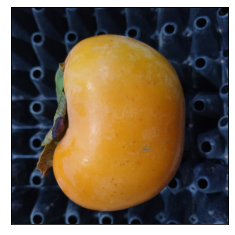

In [ ]:
import albumentations as A

image = plt.imread('/content/Persimmon/JPEGImages/Perssimon.110.jpg')

transform = A.Compose([
		# 변환할 함수들 리스트
    A.HorizontalFlip(p=1),
])

transformed = transform(image=image)
transformed_image = transformed['image']

plt.imshow(transformed_image)
plt.xticks([]); plt.yticks([])
plt.show()

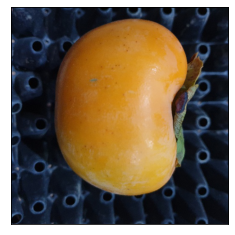

In [ ]:
image = plt.imread('/content/Persimmon/JPEGImages/Perssimon.110.jpg')

transform = A.Compose([
		# 변환할 함수들 리스트
    A.VerticalFlip(p=1),
])

transformed = transform(image=image)
transformed_image = transformed['image']

plt.imshow(transformed_image)
plt.xticks([]); plt.yticks([])
plt.show()

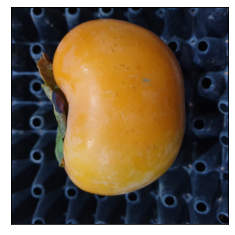

In [ ]:
image = plt.imread('/content/Persimmon/JPEGImages/Perssimon.110.jpg')

transform = A.Compose([
		# 변환할 함수들 리스트
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
])

transformed = transform(image=image)
transformed_image = transformed['image']

plt.imshow(transformed_image)
plt.xticks([]); plt.yticks([])
plt.show()

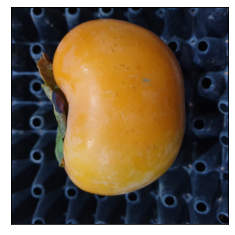

In [ ]:
image = plt.imread('/content/Persimmon/JPEGImages/Perssimon.110.jpg')

transform = A.Compose([
		# 변환할 함수들 리스트
    A.RandomRotate90(always_apply=True,p = 1)
])

transformed = transform(image=image)
transformed_image = transformed['image']

plt.imshow(transformed_image)
plt.xticks([]); plt.yticks([])
plt.show()
        

<function matplotlib.pyplot.show>

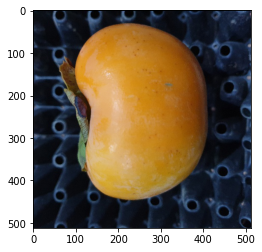

In [ ]:
image = plt.imread('/content/Persimmon/JPEGImages/Perssimon.110.jpg')
result = im_rotate(image, 180) 
plt.imshow(result)
plt.show

In [ ]:
!mkdir NewPersimmon
!mkdir NewPersimmon/Annotations
!mkdir NewPersimmon/JPEGImages

In [ ]:
# 이미지 저장 함수
ImageNumber = 0
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
cv2.imwrite(f"NewPersimmon1/JPEGImages/persimmon.{ImageNumber}.jpg", result)

True